# Twitter Sentiment Analysis Classification

## Libraries

In [3]:
import numpy as np
import pandas as pd
import regex as re
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
from tqdm import tqdm
from functools import reduce

## Dataset Load

In [2]:
!curl "https://dbdmg.polito.it/dbdmg_web/wp-content/uploads/2021/12/DSL2122_january_dataset.zip" -Lo dataset.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 17.7M  100 17.7M    0     0  16.9M      0  0:00:01  0:00:01 --:--:-- 16.9M


In [3]:
!unzip -q dataset.zip; rm dataset.zip; rm -r __MACOSX/

In [7]:
tweets = pd.read_csv("./DSL2122_january_dataset/development.csv")
tweets = tweets[:1000]

## Data exploration

In [5]:
len(tweets["user"].unique())

99

In [6]:
len(tweets["ids"].unique())

100

In [7]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  100 non-null    int64 
 1   ids        100 non-null    int64 
 2   date       100 non-null    object
 3   flag       100 non-null    object
 4   user       100 non-null    object
 5   text       100 non-null    object
dtypes: int64(2), object(4)
memory usage: 4.8+ KB


In [8]:
tweets["date"]

0     Mon May 18 01:08:27 PDT 2009
1     Sun May 31 06:23:17 PDT 2009
2     Mon Jun 01 11:52:54 PDT 2009
3     Sun May 17 02:45:34 PDT 2009
4     Tue Jun 02 00:08:07 PDT 2009
                  ...             
95    Sun Jun 07 05:10:27 PDT 2009
96    Wed Jun 03 00:58:05 PDT 2009
97    Mon Jun 15 04:44:29 PDT 2009
98    Sat Jun 06 06:13:25 PDT 2009
99    Thu May 14 08:29:12 PDT 2009
Name: date, Length: 100, dtype: object

The _date_ feature contains several different information, these are retrived with the following lines of code

In [9]:
tweets[["day_of_week", "month_of_year", "day_of_month", "time", "tz", "year"]] = tweets['date'].str.split(' ', expand=True)

In [10]:
tweets[["hour_of_day", "minute", "second"]] = tweets['time'].str.split(':', expand=True)

At this point, the information whose information have been extracted, can be removed

In [11]:
tweets.drop(columns=["date", "time"], inplace=True)

In [12]:
tweets["flag"].unique()

array(['NO_QUERY'], dtype=object)

In [13]:
tweets["tz"].unique()

array(['PDT'], dtype=object)

In [14]:
tweets["year"].unique()

array(['2009'], dtype=object)

Since the dataset containes only dates in Pacific Daylight Time (PDT) format and only for the year 2009, these features are not relevant and can be dropped.
The flag feature does not contain any useful info and minutes and seconds do not convey any information so they can be removed as well.

In [15]:
tweets.drop(columns=["tz", "year", "minute", "second", "flag"], inplace=True)

Instead of taking into account the specific hour, I decided that it is better to characterize the record by specifing if they were written in night hours (from 18 to 5) or in daylight hourse (from 6 to 17).

_night_ is a boolean feature

In [16]:
tweets["night"] = (tweets["hour_of_day"].astype("int") >= 18) | (tweets["hour_of_day"].astype("int") <= 5)

In [17]:
#tweets.drop(columns=["hour_of_day"], inplace=True) // Choose to remove it or not

In [18]:
tweets

,sentiment,ids,user,text,day_of_week,month_of_year,day_of_month,hour_of_day,night
0,1,1833972543,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",Mon,May,18,01,True
1,1,1980318193,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,Sun,May,31,06,False
2,1,1994409198,yaseminx3,@PleaseBeMine Something for your iphone,Mon,Jun,01,11,False
3,0,1824749377,no_surprises,@GabrielSaporta couldn't get in to the after p...,Sun,May,17,02,True
4,0,2001199113,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,Tue,Jun,02,00,True
...,...,...,...,...,...,...,...,...,...
95,1,2064085981,kreativlink,"@bndesign Good! In this times, it's hard to ma...",Sun,Jun,07,05,True
96,1,2014264403,rhidown,"@JoshFittell woo, i totally just got a hater t...",Wed,Jun,03,00,True
97,0,2176782067,sochews,@avrilchan Nothing from the window. No time to...,Mon,Jun,15,04,True
98,1,2053972277,viveksingh,back home plans changed now watching french op...,Sat,Jun,06,06,False


### Hashtag and mentioned user extraction

In [8]:
tweets["hashtags"] = list(map(lambda t : " ".join(re.findall("#[\d\w]+", t)), tweets["text"]))
tweets["mentioned"] = list(map(lambda t : re.findall("@[\d\w]+", t), tweets["text"]))

In [69]:
tweets["hashtags"] = list(map(lambda t : re.findall("#[\d\w]+", t), tweets["text"]))

In [75]:
hash_set = reduce(lambda a,b : set(a).union(set(b)), tweets["hashtags"])

In [76]:
len(hash_set)

3000

In [214]:
tweets["mentioned"]

0        [@MissBianca76]
1                     []
2        [@PleaseBeMine]
3      [@GabrielSaporta]
4     [@bradiewebbstack]
             ...        
95           [@bndesign]
96        [@JoshFittell]
97          [@avrilchan]
98                    []
99       [@steph_davies]
Name: mentioned, Length: 100, dtype: object

In [8]:
tweets

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,", .. , ' ... &; &;"
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,. .
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,' .
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,? .
...,...,...,...,...,...,...
224989,0,2261324310,Sat Jun 20 20:36:48 PDT 2009,NO_QUERY,CynthiaBuroughs,...
224990,1,1989408152,Mon Jun 01 01:25:45 PDT 2009,NO_QUERY,unitechy,
224991,0,1991221316,Mon Jun 01 06:38:10 PDT 2009,NO_QUERY,Xaan,&;
224992,0,2239702807,Fri Jun 19 08:51:56 PDT 2009,NO_QUERY,Ginger_Billie,!


In [7]:
# Text cleaning
tweets["text"] = list(map(lambda x: re.sub("(#|@[\d\w]+)|(https?://)|(www\.)", "", x), tweets["text"]))

In [216]:
np.max(list(map(lambda x: len(x), tweets["hashtags"])))

1

In [217]:
np.mean(list(map(lambda x: len(x), tweets["hashtags"])))

0.02

In media ci sono veramente pochi hashtag in ogni tweet, però in alcuni tweet ce ne sono tanti (24 in quello con più hashtags)

## Text mining

Sentiment Analysis

In [218]:
###
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

sentiment = np.array(list(map(lambda x: list(SentimentIntensityAnalyzer().polarity_scores(x).values()), tqdm(tweets["text"]))))
tweets["neg"] = sentiment[:, 0]
tweets["neu"] = sentiment[:, 1]
tweets["pos"] = sentiment[:, 2]
tweets["compound"] = sentiment[:, 3]
tweets["polarity"] = list(map(lambda x: TextBlob(x).sentiment.polarity, tqdm(tweets["text"])))
tweets["subjectivity"] = list(map(lambda x: TextBlob(x).sentiment.subjectivity, tqdm(tweets["text"])))
tweets
###

100%|██████████| 100/100 [00:00<00:00, 1440.17it/s]


,sentiment,ids,user,text,day_of_week,month_of_year,day_of_month,hour_of_day,night,hashtags,mentioned,neg,neu,pos,compound,polarity,subjectivity
0,1,1833972543,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",Mon,May,18,01,True,[],[@MissBianca76],0.092,0.625,0.283,0.5563,0.500000,0.500000
1,1,1980318193,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,Sun,May,31,06,False,[],[],0.000,0.768,0.232,0.6037,0.000000,0.000000
2,1,1994409198,yaseminx3,@PleaseBeMine Something for your iphone,Mon,Jun,01,11,False,[],[@PleaseBeMine],0.000,1.000,0.000,0.0000,0.000000,0.000000
3,0,1824749377,no_surprises,@GabrielSaporta couldn't get in to the after p...,Sun,May,17,02,True,[],[@GabrielSaporta],0.000,0.722,0.278,0.4019,0.000000,0.000000
4,0,2001199113,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,Tue,Jun,02,00,True,[],[@bradiewebbstack],0.000,0.874,0.126,0.0772,0.043750,0.793750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,2064085981,kreativlink,"@bndesign Good! In this times, it's hard to ma...",Sun,Jun,07,05,True,[],[@bndesign],0.083,0.536,0.380,0.7170,0.255208,0.570833
96,1,2014264403,rhidown,"@JoshFittell woo, i totally just got a hater t...",Wed,Jun,03,00,True,[],[@JoshFittell],0.270,0.589,0.141,-0.4336,0.000000,0.750000
97,0,2176782067,sochews,@avrilchan Nothing from the window. No time to...,Mon,Jun,15,04,True,[],[@avrilchan],0.145,0.855,0.000,-0.2960,-0.155556,0.288889
98,1,2053972277,viveksingh,back home plans changed now watching french op...,Sat,Jun,06,06,False,[],[],0.000,1.000,0.000,0.0000,0.000000,0.375000


In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords as sw
class LemmaTokenizer(object):
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()
    def __call__(self, document):
        lemmas = []
        for t in word_tokenize(document):
            t = t.strip()
            lemma = self.lemmatizer.lemmatize(t)
            lemmas.append(lemma)
        return lemmas

lemmaTokenizer = LemmaTokenizer()                                                                      
vectorizer = TfidfVectorizer(tokenizer=lemmaTokenizer, stop_words=sw.words('english'), strip_accents="ascii", use_idf=False, min_df=0.01)
tfidf = vectorizer.fit_transform(tweets["text"])

/Users/gio/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ["'d", "'ll", "'re", "'s", "'ve", 'could', 'doe', 'ha', 'might', 'must', "n't", 'need', 'sha', 'wa', 'wo', 'would'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [10]:
tweets_text_tfidf = pd.DataFrame(tfidf.toarray(), columns=vectorizer.get_feature_names())
tweets_text_tfidf

,!,#,&,','d,'ll,'m,'re,'s,'ve,...,wo,work,working,would,x,xx,ya,yeah,year,yes
0,0.000000,0.000000,0.400000,0.0,0.0,0.0,0.0,0.0,0.2,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.2
1,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.000000,0.333333,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
996,0.948683,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
997,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
998,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.408248,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
tweets

,sentiment,ids,date,flag,user,text
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going..."
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...
...,...,...,...,...,...,...
995,0,2259708714,Sat Jun 20 18:01:59 PDT 2009,NO_QUERY,Extremo,"#Trendio Shit, I didn't buy Mark Webber cos I ..."
996,1,1976636395,Sat May 30 18:38:30 PDT 2009,NO_QUERY,MattieJ,take that Osbad!!!
997,1,2176035835,Mon Jun 15 02:43:34 PDT 2009,NO_QUERY,wyndwitch,@TheCrystalLady DM you
998,0,1972555390,Sat May 30 09:26:45 PDT 2009,NO_QUERY,amy__xx,party time at 7.... :S work tomorrow though so...


In [12]:
tweets = pd.concat((tweets, tweets_text_tfidf), axis=1)
tweets

,sentiment,ids,date,flag,user,text,!,#,&,',...,wo,work,working,would,x,xx,ya,yeah,year,yes
0,1,1833972543,Mon May 18 01:08:27 PDT 2009,NO_QUERY,Killandra,"@MissBianca76 Yes, talking helps a lot.. going...",0.000000,0.000000,0.400000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.2
1,1,1980318193,Sun May 31 06:23:17 PDT 2009,NO_QUERY,IMlisacowan,SUNSHINE. livingg itttt. imma lie on the grass...,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,1,1994409198,Mon Jun 01 11:52:54 PDT 2009,NO_QUERY,yaseminx3,@PleaseBeMine Something for your iphone,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1824749377,Sun May 17 02:45:34 PDT 2009,NO_QUERY,no_surprises,@GabrielSaporta couldn't get in to the after p...,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0,2001199113,Tue Jun 02 00:08:07 PDT 2009,NO_QUERY,Rhi_ShortStack,@bradiewebbstack awww is andy being mean again...,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,2259708714,Sat Jun 20 18:01:59 PDT 2009,NO_QUERY,Extremo,"#Trendio Shit, I didn't buy Mark Webber cos I ...",0.000000,0.333333,0.000000,0.0,...,0.0,0.000000,0.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0
996,1,1976636395,Sat May 30 18:38:30 PDT 2009,NO_QUERY,MattieJ,take that Osbad!!!,0.948683,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
997,1,2176035835,Mon Jun 15 02:43:34 PDT 2009,NO_QUERY,wyndwitch,@TheCrystalLady DM you,0.000000,0.000000,0.000000,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
998,0,1972555390,Sat May 30 09:26:45 PDT 2009,NO_QUERY,amy__xx,party time at 7.... :S work tomorrow though so...,0.000000,0.000000,0.000000,0.0,...,0.0,0.408248,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


---
Potremmo provare ad estrarre informazioni utili dagli username?
Da implementare in seguito...
---

In [219]:
tweets.drop(columns=["user", "text", "mentioned", "hashtags"], inplace=True)

In [220]:
tweets

,sentiment,ids,day_of_week,month_of_year,day_of_month,hour_of_day,night,neg,neu,pos,compound,polarity,subjectivity
0,1,1833972543,Mon,May,18,01,True,0.092,0.625,0.283,0.5563,0.500000,0.500000
1,1,1980318193,Sun,May,31,06,False,0.000,0.768,0.232,0.6037,0.000000,0.000000
2,1,1994409198,Mon,Jun,01,11,False,0.000,1.000,0.000,0.0000,0.000000,0.000000
3,0,1824749377,Sun,May,17,02,True,0.000,0.722,0.278,0.4019,0.000000,0.000000
4,0,2001199113,Tue,Jun,02,00,True,0.000,0.874,0.126,0.0772,0.043750,0.793750
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,2064085981,Sun,Jun,07,05,True,0.083,0.536,0.380,0.7170,0.255208,0.570833
96,1,2014264403,Wed,Jun,03,00,True,0.270,0.589,0.141,-0.4336,0.000000,0.750000
97,0,2176782067,Mon,Jun,15,04,True,0.145,0.855,0.000,-0.2960,-0.155556,0.288889
98,1,2053972277,Sat,Jun,06,06,False,0.000,1.000,0.000,0.0000,0.000000,0.375000


## Preprocessing

---
Implement weekday and weekend

---

Map the days of the week into integers

In [221]:
day_of_week_dict = {"Mon": 1, "Tue": 2, "Wed": 3, "Thu": 4, "Fri": 5, "Sat": 6, "Sun": 7}
tweets["day_of_week"] = list(map(lambda x: day_of_week_dict[x], tweets["day_of_week"]))

Map the months of the year into integers

In [222]:
months_dict = {"Jan": 1, "Feb": 2, "Mar": 3, "Apr": 4, "May": 5, "Jun": 6, "Jul": 7, "Aug": 8, "Sep": 9, "Oct": 10, "Nov": 11, "Dec": 12}
tweets["month_of_year"] = list(map(lambda x: months_dict[x], tweets["month_of_year"]))

Convert day and hours into integers

In [223]:
tweets["day_of_month"] = list(map(lambda x: int(x), tweets["day_of_month"]))

In [224]:
tweets["hour_of_day"] = list(map(lambda x: int(x), tweets["hour_of_day"]))

Normalize _ids_ attribute

In [225]:
y = tweets.pop("sentiment")
y

0     1
1     1
2     1
3     0
4     0
     ..
95    1
96    1
97    0
98    1
99    1
Name: sentiment, Length: 100, dtype: int64

In [227]:
X = pd.DataFrame(MinMaxScaler().fit_transform(tweets), columns=tweets.columns)
X

,ids,day_of_week,month_of_year,day_of_month,hour_of_day,night,neg,neu,pos,compound,polarity,subjectivity
0,0.426403,0.000000,0.5,0.566667,0.043478,1.0,0.166667,0.523507,0.440124,0.776490,0.833333,0.500000
1,0.597420,1.000000,0.5,1.000000,0.260870,0.0,0.000000,0.705210,0.360809,0.803816,0.555556,0.000000
2,0.613886,0.000000,1.0,0.000000,0.478261,0.0,0.000000,1.000000,0.000000,0.455782,0.555556,0.000000
3,0.415625,1.000000,0.5,0.533333,0.086957,1.0,0.000000,0.646760,0.432348,0.687478,0.555556,0.000000
4,0.621821,0.166667,1.0,0.033333,0.000000,1.0,0.000000,0.839898,0.195956,0.500288,0.579861,0.793750
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.695310,1.000000,1.0,0.200000,0.217391,1.0,0.150362,0.410419,0.590980,0.869134,0.697338,0.570833
96,0.637089,0.333333,1.0,0.066667,0.000000,1.0,0.489130,0.477764,0.219285,0.205811,0.555556,0.750000
97,0.827004,0.000000,1.0,0.466667,0.173913,1.0,0.262681,0.815756,0.000000,0.285138,0.469136,0.288889
98,0.683491,0.833333,1.0,0.166667,0.260870,0.0,0.000000,1.000000,0.000000,0.455782,0.555556,0.375000


In [65]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y)
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
f1_score(y_test, y_pred, average="macro")

0.5833333333333334

In [77]:
def get_variables_importance(classifier, df):
    importance = classifier.feature_importances_
    forest_importance = pd.Series(importance, index=df.columns)
    fig, ax = plt.subplots()
    forest_importance.plot.bar(ax=ax)
    ax.set_title("Feature importance")
    ax.set_title("Values")
    fig.tight_layout()
    
    plt.show()

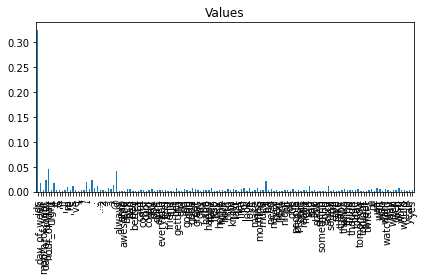

In [78]:
get_variables_importance(clf, X)